In [1]:
from scipy.io import loadmat, savemat
from pathlib import Path
import matplotlib.pyplot as plt
from scipy import signal
import cmath
import numpy as np
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

C:\Users\sarfi\anaconda3\envs\allendata\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Example Data

https://github.com/mullerlab/generalized-phase

In [2]:
data = loadmat(Path.home() / 'Desktop' / 'x.mat')['x']

In [3]:
data.shape

(681, 1)

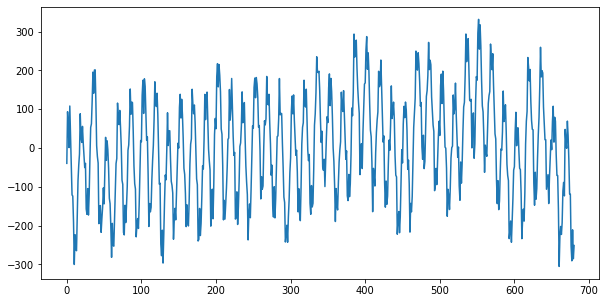

In [4]:
plt.figure(figsize=(10,5))
plt.plot(data)

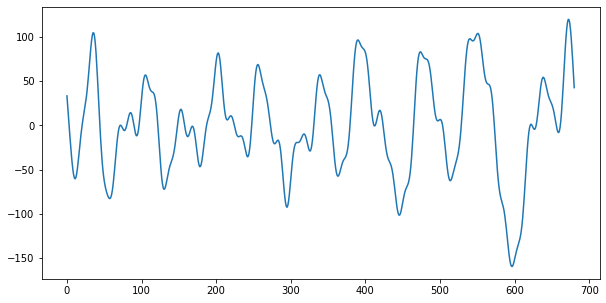

In [5]:
nyquist = 0.5 * 1200
low = 5 / nyquist
high = 50 / nyquist
order = 3

b, a = signal.butter(order, [low, high], btype='band')

# Apply the filter to the signal using filtfilt for zero-phase filtering
filtered_data = signal.filtfilt(b, a, data[:,0])

plt.figure(figsize=(10,5))
plt.plot(filtered_data)

In [6]:
# generalized phase, computed in MATLAB
gp_data = loadmat(Path.home() / 'Desktop' / 'xgp.mat')['xgp']

In [7]:
gp_data[0,0]
# complex numbers
# angle = phase

(8.628042825698163+84.80137808040422j)

In [8]:
gp_data.shape

(681, 1)

In [9]:
z1 = gp_data[0,0]
cmath.phase(z1)* 180 / cmath.pi

84.19048191363504

In [10]:
phase_angles = np.zeros(gp_data.shape)
for i in range(gp_data.shape[0]):
    z = gp_data[i,0]
    # print(z2)
    phase_angles[i,0] = cmath.phase(z) * 180 / cmath.pi

In [11]:
print(phase_angles.max())
print(phase_angles.min())
phase_angles.shape

179.61282969142383
-179.93575278569614


(681, 1)

In [12]:
filtered_data.shape

(681,)

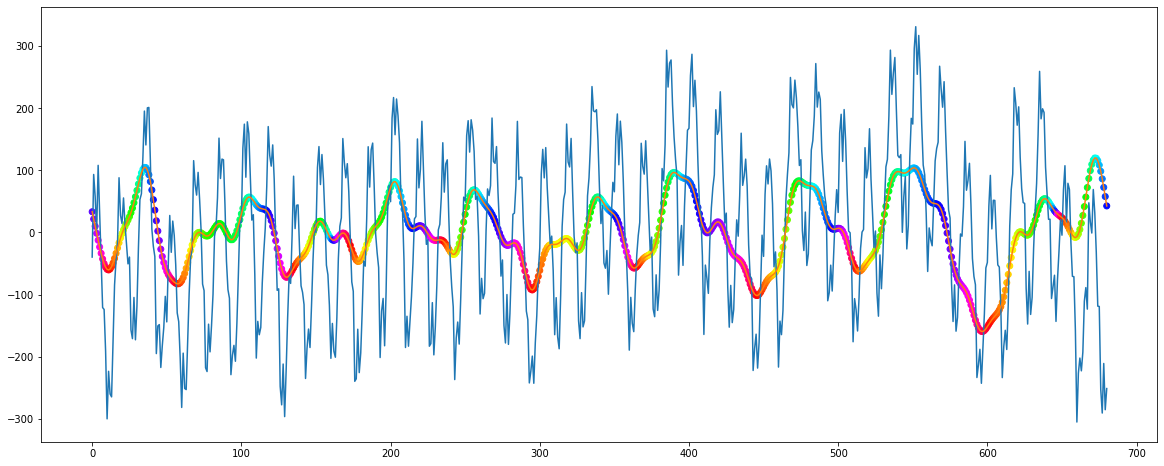

In [13]:
plt.figure(figsize=(20,8))

import matplotlib
cmap = 'hsv'

norm = matplotlib.colors.Normalize(vmin=-180, vmax=180)

c = norm(phase_angles[:,0])

plt.plot(data)
plt.plot(filtered_data)
plt.scatter(np.arange(filtered_data.shape[0]), filtered_data, c=c, cmap='hsv')

### Replicating MATLAB GP preprocessing in Python

In [55]:
(python_xw-xw).shape
# plt.plot(python_xw-xw)

(681, 681)

In [47]:
python_xw.shape

(681,)

C:\Users\sarfi\anaconda3\envs\allendata\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


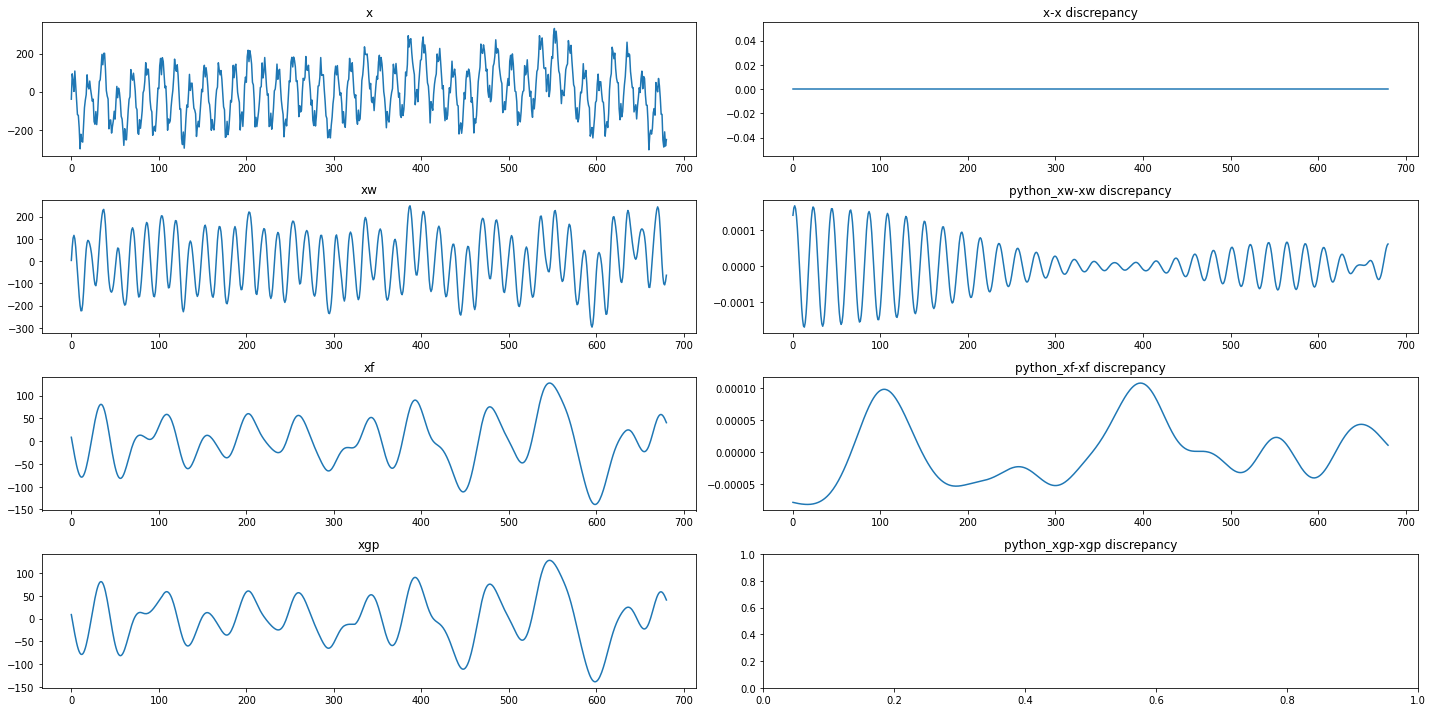

In [63]:
order = 4
Fs = 1250
lp = 0

# x = data[:,0]

b, a = signal.butter(order, np.array([5, 200])/(Fs/2), btype='band') # 4th order Butterworth 5-200Hz bandpass filter. Fs/2 -> Nyquist frequency
xw = signal.filtfilt(b, a, x[:,0], padtype = 'odd', padlen=3*(max(len(b),len(a))-1)) # padlen fix from https://dsp.stackexchange.com/a/47945

b, a = signal.butter(order, np.array([58, 62])/(Fs/2), btype='stop')
xw = signal.filtfilt(b, a, xw, padtype = 'odd', padlen=3*(max(len(b),len(a))-1))

b, a = signal.butter(order, np.array([115, 125])/(Fs/2), btype='stop')
python_xw = signal.filtfilt(b, a, xw, padtype = 'odd', padlen=3*(max(len(b),len(a))-1))



b, a = signal.butter(order, np.array([5, 40])/(Fs/2), btype='band')
python_xf = signal.filtfilt(b, a, x[:,0], padtype = 'odd', padlen=3*(max(len(b),len(a))-1))
       
# savemat('python_xw.mat', {'xw': xw})
# savemat('python_xf.mat', {'xf': xf})

# xgp = generalized_phase_vector( xf, Fs, lp );


# plt.figure(figsize=(10,5))
# plt.plot(xw)
# plt.plot(xf)

x = loadmat(Path.home() / 'Desktop' / 'x.mat')['x']

xw = loadmat(Path.home() / 'Desktop' / 'xw.mat')['xw']
# python_xw = loadmat(Path.home() / 'Desktop' / 'python_xw.mat')['xw'].T
xf = loadmat(Path.home() / 'Desktop' / 'xf.mat')['xf']
# python_xf = loadmat(Path.home() / 'Desktop' / 'python_xf.mat')['xf'].T
xgp = loadmat(Path.home() / 'Desktop' / 'xgp.mat')['xgp']
python_xgp = loadmat(Path.home() / 'Desktop' / 'python_xgp.mat')['xgp']

fig, axes = plt.subplots(nrows=4,ncols=2, figsize=(20,10))
axes[0,0].plot(x)
axes[0,0].set_title('x')
axes[0,1].plot(x-x)
axes[0,1].set_title('x-x discrepancy')
axes[1,0].plot(xw)
axes[1,0].set_title('xw')
axes[1,1].plot(python_xw-xw[:,0])
axes[1,1].set_title('python_xw-xw discrepancy')
axes[2,0].plot(xf)
axes[2,0].set_title('xf')
axes[2,1].plot(python_xf-xf[:,0])
axes[2,1].set_title('python_xf-xf discrepancy')
axes[3,0].plot(xgp)
axes[3,0].set_title('xgp')
# axes[3,1].plot(python_xgp-xgp) # TO BE RECOMPUTED
axes[3,1].set_title('python_xgp-xgp discrepancy')

plt.tight_layout()
plt.show()

### Allen Data

In [15]:
output_dir = Path.home() / 'Desktop' / 'ecephys_data'
cache = EcephysProjectCache.from_warehouse(manifest = output_dir / 'manifest.json')

session_id = 715093703
session = cache.get_session_data(session_id)

VISp_probe_id = 810755801
lfp = session.get_lfp(VISp_probe_id)

In [16]:
# this works for selecting interesting channels and time ranges
lfp.sel(channel=[850261814,850261790]).sel(time=slice(29, 30)).data.shape

(1250, 2)

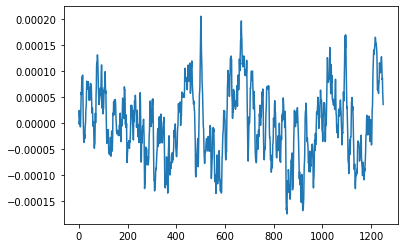

In [17]:
# saving as a mat file
data_to_save = lfp.sel(channel=[850261814]).sel(time=slice(29, 30)).data

plt.plot(data_to_save)
plt.show()

# savemat('allen_data.mat', {'x': data_to_save})

In [57]:
# gp_data = loadmat(Path.home() / 'Desktop' / 'allen_xgp.mat')['xgp']